In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!sudo rm -rf /content/*
!cp -r "/content/drive/MyDrive/BSAI23009" /content/
! pip install opencv-python pandas matplotlib tqdm

In [3]:
import os
import cv2
import pandas as pd
import glob
from tqdm import tqdm

# --- CONFIGURATION ---
DATASET_ROOT = "/content//BSAI23009"
OUTPUT_DIR = "/content/processed_data/crops"
CSV_PATH = "/content/processed_data/crops.csv"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Decoders
GENDER_MAP = {0: "N/V", 1: "Male", 2: "Female", 20: "Ignore"}
COLOR_MAP = {0: "N/V", 1: "Red", 2: "Blue", 3: "Yellow", 4: "Green", 5: "Orange",
             6: "Purple", 7: "Pink", 8: "Brown", 9: "Black", 10: "White", 11: "Gray", 20: "Ignore"}

csv_data = []

# Process folders 1 through 10
for folder_num in range(1, 11):
    folder = str(folder_num)
    img_dir = os.path.join(DATASET_ROOT, folder, "images")
    ann_attr_dir = os.path.join(img_dir, "Annotations_attributes")

    if not os.path.exists(ann_attr_dir):
        print(f"Skipping folder {folder}: Not found.")
        continue

    txt_files = glob.glob(os.path.join(ann_attr_dir, "*.txt"))

    for txt_path in tqdm(txt_files, desc=f"Cropping Folder {folder}"):
        base_name = os.path.splitext(os.path.basename(txt_path))[0]
        img_path = os.path.join(img_dir, base_name + ".png")

        image = cv2.imread(img_path)
        if image is None: continue
        img_h, img_w = image.shape[:2]

        with open(txt_path, 'r') as f:
            for ann_id, line in enumerate(f):
                parts = line.strip().split()
                if not parts or int(parts[0]) != 0: continue # Only Person (0)

                # Parse
                cls_id, x_c, y_c, w_norm, h_norm = int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
                gen, face, up_col, low_col = int(parts[5]), int(parts[6]), int(parts[7]), int(parts[8])

                # Bounding Box math
                x1 = int((x_c - w_norm/2) * img_w)
                y1 = int((y_c - h_norm/2) * img_h)
                x2 = int((x_c + w_norm/2) * img_w)
                y2 = int((y_c + h_norm/2) * img_h)

                # Crop and Save
                crop_filename = f"ob1_{base_name}_{ann_id}.png"
                crop = image[max(0,y1):min(img_h,y2), max(0,x1):min(img_w,x2)]
                if crop.size == 0: continue
                cv2.imwrite(os.path.join(OUTPUT_DIR, crop_filename), crop)

                # Store for CSV
                csv_data.append({
                    "crop_filename": crop_filename, "original_image": base_name + ".png",
                    "ann_id": ann_id, "x": x1, "y": y1, "w": x2-x1, "h": y2-y1,
                    "gender": GENDER_MAP.get(gen, "N/V"),
                    "upper_color": COLOR_MAP.get(up_col, "N/V"),
                    "lower_color": COLOR_MAP.get(low_col, "N/V")
                })

# Save CSV
df = pd.DataFrame(csv_data)
df.to_csv(CSV_PATH, index=False)
print(f"\nSuccessfully saved {len(df)} crops to {OUTPUT_DIR}")

Cropping Folder 10: 100%|██████████| 10/10 [00:00<00:00, 41.83it/s]


Successfully saved 1240 crops to /content/processed_data/crops


/tmp/ipython-input-1983189540.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='gender', ax=axes[0], palette="viridis")
/tmp/ipython-input-1983189540.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='upper_color', ax=axes[1], palette="magma")
/tmp/ipython-input-1983189540.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='lower_color', ax=axes[2], palette="rocket")


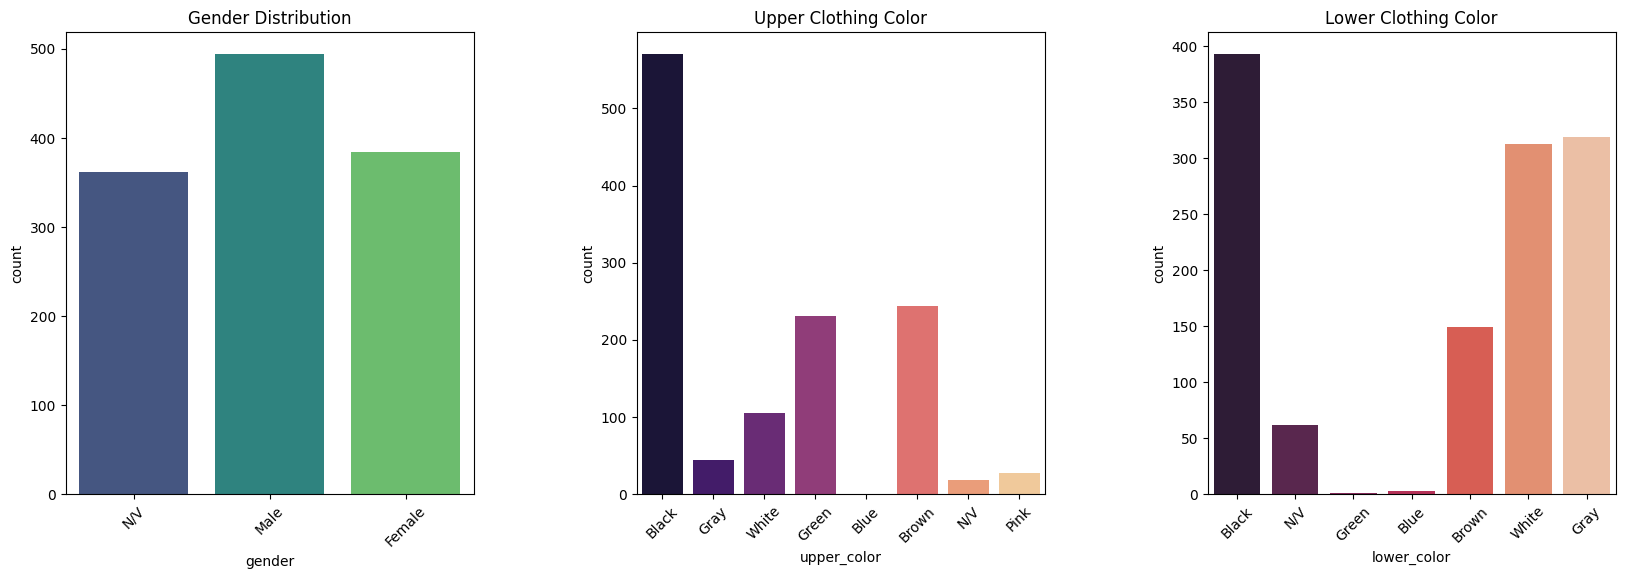

Analysis complete. Image saved as 'attribute_analysis.png'


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the dataframe created in the previous cell
if 'df' in locals():
    # Setup the figure for 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.4)

    # 1. Gender Distribution
    sns.countplot(data=df, x='gender', ax=axes[0], palette="viridis")
    axes[0].set_title("Gender Distribution")
    axes[0].tick_params(axis='x', rotation=45)

    # 2. Upper Clothing Color Distribution
    sns.countplot(data=df, x='upper_color', ax=axes[1], palette="magma")
    axes[1].set_title("Upper Clothing Color")
    axes[1].tick_params(axis='x', rotation=45)

    # 3. Lower Clothing Color Distribution
    sns.countplot(data=df, x='lower_color', ax=axes[2], palette="rocket")
    axes[2].set_title("Lower Clothing Color")
    axes[2].tick_params(axis='x', rotation=45)

    # Save the analysis
    plt.savefig('/content/processed_data/attribute_analysis.png', bbox_inches='tight')
    plt.show()

    print("Analysis complete. Image saved as 'attribute_analysis.png'")
else:
    print("Error: Please run the first cell to generate the data first!")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


Starting Training on cuda...
Classes: Gender(4), Colors(13)
Epoch [1/15] Loss: 4.2052 | Acc Gender: 64.1% | Acc Upper: 52.8% | Acc Lower: 44.8%
Epoch [2/15] Loss: 3.2046 | Acc Gender: 68.5% | Acc Upper: 55.2% | Acc Lower: 52.4%
Epoch [3/15] Loss: 2.7547 | Acc Gender: 69.4% | Acc Upper: 61.3% | Acc Lower: 55.6%
Epoch [4/15] Loss: 2.5223 | Acc Gender: 59.7% | Acc Upper: 60.1% | Acc Lower: 59.7%
Epoch [5/15] Loss: 2.2566 | Acc Gender: 67.7% | Acc Upper: 63.7% | Acc Lower: 53.6%
Epoch [6/15] Loss: 1.9628 | Acc Gender: 68.1% | Acc Upper: 71.4% | Acc Lower: 66.5%
Epoch [7/15] Loss: 1.6756 | Acc Gender: 81.0% | Acc Upper: 73.4% | Acc Lower: 62.5%
Epoch [8/15] Loss: 1.4458 | Acc Gender: 78.2% | Acc Upper: 66.9% | Acc Lower: 62.9%
Epoch [9/15] Loss: 1.3443 | Acc Gender: 68.1% | Acc Upper: 58.9% | Acc Lower: 56.5%
Epoch [10/15] Loss: 1.1416 | Acc Gender: 77.4% | Acc Upper: 70.6% | Acc Lower: 66.1%
Epoch [11/15] Loss: 0.8036 | Acc Gender: 77.0% | Acc Upper: 74.2% | Acc Lower: 72.2%
Epoch [12/15] 

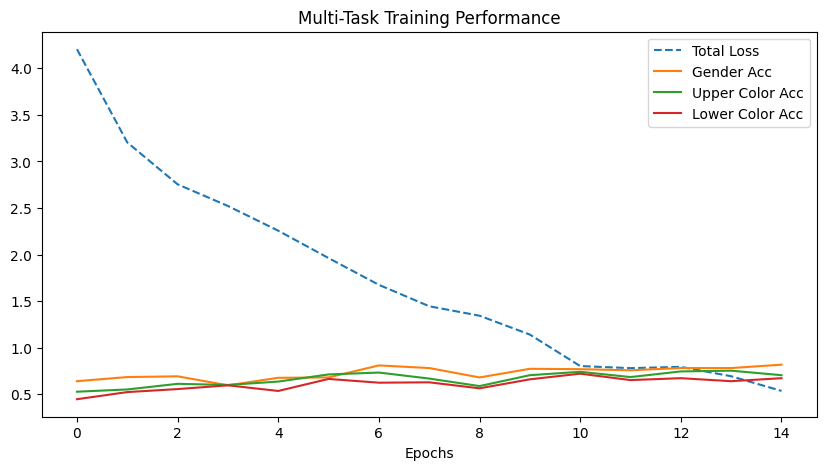

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
BATCH_SIZE = 32
EPOCHS = 15  # Increased epochs for multi-task learning
LEARNING_RATE = 0.0005 # Lower LR for stability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data to build Encoders
df = pd.read_csv(CSV_PATH)

# Robust Label Encoding (Handling Strings from CSV)
gender_encoder = LabelEncoder()
color_encoder = LabelEncoder()

# Fit encoders on all possible known values to ensure consistency
known_genders = ["Male", "Female", "N/V", "Ignore"]
known_colors = ["Red", "Blue", "Yellow", "Green", "Orange", "Purple", "Pink",
                "Brown", "Black", "White", "Gray", "N/V", "Ignore"]

gender_encoder.fit(known_genders)
color_encoder.fit(known_colors)

# --- 1. ROBUST DATASET CLASS ---
class MultiTaskDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = os.path.join(self.img_dir, row['crop_filename'])

        # Image Loading with Error Handling
        try:
            image = Image.open(img_name).convert("RGB")
        except (OSError, FileNotFoundError):
            # Fallback for bad images: return a black image (prevents crash)
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        # Encode Labels
        gender_label = gender_encoder.transform([row['gender']])[0]
        upper_label = color_encoder.transform([row['upper_color']])[0]
        lower_label = color_encoder.transform([row['lower_color']])[0]

        if self.transform:
            image = self.transform(image)

        return image, gender_label, upper_label, lower_label

# --- 2. MULTI-HEAD MODEL ARCHITECTURE ---
class MultiHeadResNet(nn.Module):
    def __init__(self, n_genders, n_colors):
        super(MultiHeadResNet, self).__init__()
        # Backbone
        self.base_model = models.resnet18(pretrained=True)
        n_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity() # Remove original head

        # Three Separate Heads
        self.gender_head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, n_genders)
        )
        self.upper_head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, n_colors)
        )
        self.lower_head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, n_colors)
        )

    def forward(self, x):
        features = self.base_model(x)
        return self.gender_head(features), self.upper_head(features), self.lower_head(features)

# --- 3. PREPARATION ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # Augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = MultiTaskDataset(train_df, OUTPUT_DIR, transform=transform)
val_dataset = MultiTaskDataset(val_df, OUTPUT_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Initialize Model
model = MultiHeadResNet(n_genders=len(gender_encoder.classes_),
                        n_colors=len(color_encoder.classes_)).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=color_encoder.transform(["Ignore"])[0]) # Ignore class 20

# --- 4. VERBOSE TRAINING LOOP ---
history = {'loss': [], 'g_acc': [], 'u_acc': [], 'l_acc': []}

print(f"Starting Training on {DEVICE}...")
print(f"Classes: Gender({len(gender_encoder.classes_)}), Colors({len(color_encoder.classes_)})")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for imgs, g_labels, u_labels, l_labels in train_loader:
        imgs = imgs.to(DEVICE)
        g_labels, u_labels, l_labels = g_labels.to(DEVICE), u_labels.to(DEVICE), l_labels.to(DEVICE)

        optimizer.zero_grad()

        # Forward Pass (3 Outputs)
        g_out, u_out, l_out = model(imgs)

        # Calculate Individual Losses
        loss_g = criterion(g_out, g_labels)
        loss_u = criterion(u_out, u_labels)
        loss_l = criterion(l_out, l_labels)

        # Total Loss (Weighted sum can be used, here equal weight)
        total_loss = loss_g + loss_u + loss_l

        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item()

    # Validation Phase
    model.eval()
    val_loss = 0
    g_corr, u_corr, l_corr = 0, 0, 0
    total = 0

    with torch.no_grad():
        for imgs, g_labels, u_labels, l_labels in val_loader:
            imgs = imgs.to(DEVICE)
            g_labels, u_labels, l_labels = g_labels.to(DEVICE), u_labels.to(DEVICE), l_labels.to(DEVICE)

            g_out, u_out, l_out = model(imgs)

            # Accuracy Check
            g_corr += (g_out.argmax(1) == g_labels).sum().item()
            u_corr += (u_out.argmax(1) == u_labels).sum().item()
            l_corr += (l_out.argmax(1) == l_labels).sum().item()
            total += g_labels.size(0)

    # Verbose Output
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Loss: {running_loss/len(train_loader):.4f} | "
          f"Acc Gender: {100*g_corr/total:.1f}% | "
          f"Acc Upper: {100*u_corr/total:.1f}% | "
          f"Acc Lower: {100*l_corr/total:.1f}%")

    history['loss'].append(running_loss/len(train_loader))
    history['g_acc'].append(g_corr/total)
    history['u_acc'].append(u_corr/total)
    history['l_acc'].append(l_corr/total)

# Plotting Curves
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Total Loss', linestyle='--')
plt.plot(history['g_acc'], label='Gender Acc')
plt.plot(history['u_acc'], label='Upper Color Acc')
plt.plot(history['l_acc'], label='Lower Color Acc')
plt.title("Multi-Task Training Performance")
plt.xlabel("Epochs")
plt.legend()
plt.savefig("train_curves.png")
print("Training Complete. Curves saved.")

In [6]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np # Ensure numpy is imported

model.eval()

# Storage for predictions and ground truth
true_g, pred_g = [], []
true_u, pred_u = [], []
true_l, pred_l = [], []

print("Running comprehensive evaluation...")

with torch.no_grad():
    for imgs, g_labels, u_labels, l_labels in val_loader:
        imgs = imgs.to(DEVICE)

        # Get predictions
        g_out, u_out, l_out = model(imgs)

        # Convert to class indices
        pred_g.extend(g_out.argmax(1).cpu().numpy())
        pred_u.extend(u_out.argmax(1).cpu().numpy())
        pred_l.extend(l_out.argmax(1).cpu().numpy())

        true_g.extend(g_labels.cpu().numpy())
        true_u.extend(u_labels.cpu().numpy())
        true_l.extend(l_labels.cpu().numpy())

# --- FIX IS IN THIS FUNCTION ---
def get_report_df(y_true, y_pred, encoder, task_name):
    # We generate a range of IDs [0, 1, 2, ...] matching the encoder length
    all_labels = range(len(encoder.classes_))

    report = classification_report(
        y_true, y_pred,
        labels=all_labels,             # <--- FORCE SKLEARN TO USE ALL DEFINED LABELS
        target_names=encoder.classes_, # Map names to those specific labels
        output_dict=True,
        zero_division=0                # Handle cases where a class is missing in val data
    )
    df = pd.DataFrame(report).transpose()
    df['Task'] = task_name
    return df

# Generate reports
df_g = get_report_df(true_g, pred_g, gender_encoder, "Gender")
df_u = get_report_df(true_u, pred_u, color_encoder, "Upper_Color")
df_l = get_report_df(true_l, pred_l, color_encoder, "Lower_Color")

# Combine and Save
final_metrics = pd.concat([df_g, df_u, df_l])
final_metrics.to_csv("metrics.csv")

print("\nEvaluation Complete.")
print(f"Metrics saved to 'metrics.csv' with {len(final_metrics)} rows.")

print("\n--- Quick Summary (Weighted Avg F1-Score) ---")
print(f"Gender:      {df_g.loc['weighted avg', 'f1-score']:.4f}")
print(f"Upper Color: {df_u.loc['weighted avg', 'f1-score']:.4f}")
print(f"Lower Color: {df_l.loc['weighted avg', 'f1-score']:.4f}")

Running comprehensive evaluation...

Evaluation Complete.
Metrics saved to 'metrics.csv' with 39 rows.

--- Quick Summary (Weighted Avg F1-Score) ---
Gender:      0.7980
Upper Color: 0.6995
Lower Color: 0.6553


In [7]:
!cp -rf /content/processed_data /content/drive/MyDrive
